In [1]:
import cv2                                # Image processing
from matplotlib import pyplot as plt      # Plotting
import numpy as np                        # Maths
import imutils                            # Image processing
import copy                               # Deepcopy function
import tifffile                           # Reading tif images

import warnings
warnings.filterwarnings("ignore")         # Remove unnecessary pyplot warnings

In [237]:
def read_tif(fpath,scale_bar_val=None):
    """ Tries to read FEI SEM .tif image from filepath
    If there's no FEI metadata, al alternative method is used.
    
    To bypass manually entering scare bar value, enter in scale_bar_val.
    
    Returns image with scalebar cropped, pixel width, 
    image width, and image height in metres"""
    try:
        # Get image scale from metadata
        im_file = tifffile.TiffFile(fpath)
        px = im_file.fei_metadata['Scan']['PixelWidth']
        w = im_file.fei_metadata['EBeam']['HFW']
        h = im_file.fei_metadata['EBeam']['VFW']

        # Open image and crop out scale bar
        im = cv2.imread(fpath)
        lim = int(np.floor(h/px))
        im_crop = im[:lim,:]

        return im_crop, im, px, w, h

    except:
        im_crop, im_raw, px, w, h = alternate_calibration(fpath,scale_bar_val)
        return im_crop, im_raw, px, w, h

def get_contours(binary):
    """ Given a binary image, returns contours 
    Contours must be above an area/perimeter threshold"""
    try:
        contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    except:
        contours, hierarchy = cv2.findContours(binary,cv2.RETR_FLOODFILL,cv2.CHAIN_APPROX_SIMPLE)
    big_cnt = []

    for c in contours:
        area = cv2.contourArea(c)
        perim = cv2.arcLength(c,True)
        if area > 3000 or perim > 2000:
            big_cnt.append(c)
#         if np.shape(c)[0] > 150:
#             big_cnt.append(c)

    return big_cnt

def plot_contours(cnts,im,title=None):
    """ Takes contours and an image, and plots them both"""
    plt.figure()
    cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    for i in range(len(cnts)):
        plt.scatter(cnts[i][:,0][:][:,0],cnts[i][:,0][:][:,1],s=2,color=cols[i%len(cols)],alpha=0.4)
        plt.imshow(im,cmap='gray')
    if title != None:
        plt.title(title,fontsize=15)
    plt.axis('off')

def extract_contours(im, method = 'blur_fill',plot=False,sobel_clip=.4e7,bin_thresh=60,k_blur=5,k_open=3,k_sobel=11):
    """ Given a filtering method ['blur_fill','sobel'], applies filter and extracts the resulting contours
    Can be plotted if plot = True, parameters can be tuned too."""
    if method == 'blur_fill':
        # Filter 1: im -> Gray -> Blur -> Threshold -> Open
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (k_blur, k_blur), 0)
        thresh = cv2.threshold(blurred, bin_thresh, 255, cv2.THRESH_BINARY)[1]
        kernel = np.ones((k_open,k_open),np.uint8)
        opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel)
        cnts = get_contours(opening)
        pic = opening
    
    if method == 'sobel':
        # Filter 2: im -> Gray -> Sobel -> Threshold
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=k_sobel)
        sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=k_sobel)
        sobel = abs(sobelx) + abs(sobely)

        x = np.clip(sobel,0,sobel_clip)
        x = x/np.max(x)*255
        x = cv2.GaussianBlur(x, (k_blur, k_blur), 0)

        thresh = cv2.threshold(x, bin_thresh, 255, cv2.THRESH_BINARY)[1]
        thresh = thresh.astype(np.uint8)

        kernel = np.ones((k_open,k_open),np.uint8)
        opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel)
        cnts = get_contours(opening)
        pic = thresh
        
    if plot == True:
        plot_contours(cnts,pic,title=method)
        
    return cnts

def detect_shapes(cs, poly_approx_thresh=0.01):
    """ Takes a set of contours and returns new simplified contours
    which are approximated polygon shapes within a given % threshold"""
    shapes = []
    for c in cs:
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, poly_approx_thresh * peri, True)
        shapes.append(approx)
        
    # this is a bit hacky but in case there's only 1 shape found
    # cv2 defines the shape differently so you can't concatanate them later
    # easiest way round is to just add another shape which will
    # be removed in the post-filtering stage
    s0 = np.array([[[0,1]],[[1,5]],[[2,10]]])
    shapes.append(s0)
    
    return shapes

def plot_shapes(shapes,im):
    """ Plots contour shapes over an image """
    cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    for i,s in enumerate(shapes):
        x1,x2 = s[:][0,0][0],s[:][-1,0][0]
        y1,y2 = s[:][0,0][1],s[:][-1,0][1]
        plt.plot(s[:,0][:][:,0],s[:,0][:][:,1],'o-',color=cols[i%len(cols)],alpha=.6)
        plt.plot([x1,x2],[y1,y2],'o-',color=cols[i%len(cols)],alpha=.6,label=None)

    plt.imshow(im)
    plt.axis('off')
    
def fit_circles(cnts):
    """ Fits a minimum enclosing circle around each given contour.
    Returns circle centres and radii."""
    centres = []
    radii = []

    for c in cnts:
        circle = cv2.minEnclosingCircle(c)
        centres.append(circle[0])
        radii.append(circle[1])
    
    return centres, radii

def calibrate_radii(radii,px):
    """ Converts circle radii from pixel to nm
    using px pixel width """
    ds = []
    for r in radii:
        d = r * px /(1e-9) * 2
        ds.append(d)
    return ds

def plot_circles(im,cnts,centres,radii, ds,errs):
    """ Plots circles around each final shape and labels with the size"""
    fig, ax = plt.subplots(figsize=(10,14))
    plot_shapes(cnts,im)
    cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    for i in range(len(cnts)):
        circle1 = plt.Circle(centres[i], radii[i],ec=cols[i%len(cols)],fc=(0,0,0,0),lw=2,ls=':')
        ax.add_patch(circle1)

    d_str = []
    for i,d in enumerate(ds):
        d_str.append('%.1f $\pm$ %.1f nm' % (d,errs[i]))
        d_str.append('_nolegend_')
        
    plt.legend(d_str,title='Diameters',bbox_to_anchor=(1.01, .6))
    plt.axis('off')
    
def remove_identical_shapes(all_s,threshold=0.3):
    """ Takes list of contours and identifies 'identical' shapes by
    looking at ratios of enclosing circle centres, radii, contour areas and
    contour perimeters and removing those within a set threshold"""
    cents,rads = fit_circles(all_s)

    areas = []
    perims = []
    for s in all_s:
        area = cv2.contourArea(s)
        perim = cv2.arcLength(s,True)
        areas.append(area)
        perims.append(perim)

    to_remove = []
    for i in range(len(all_s)):
        c1,r1,a1,p1 = cents[i],rads[i],areas[i],perims[i]
        for j in range(len(all_s)):
            if j>=i:
                c2,r2,a2,p2 = cents[j],rads[j],areas[j],perims[j]
                tl = 1-threshold
                tu = 1+threshold
                try:
                    if i != j:
                        if tl < abs(c2[0]/c1[0]) < tu:
                            if tl < abs(c2[1]/c1[1]) < tu:
                                if tl < abs(r2/r1) < tu:
                                    if tl < abs(a2/a1) < tu:
                                        if tl < abs(p2/p1) < tu:
                                            to_remove.append(j)
                except: # fails if area = 0, so remove
                    to_remove.append(j)
    new_all_s = np.delete(all_s,to_remove)

    return new_all_s

def post_filter(cnts,px, min_avg_length = 30, max_avg_length = 150, min_points = 3 ):
    """ Remove shapes that have less than 'min_points' vertices
    Removes shapes with avg edge length < min or > max in nm"""
   
    # Remove low vertex count shapes
    new_all_s = cnts
    f1 = []
    for s in new_all_s:
        if s.shape[0] >= min_points:
            f1.append(s)
    # Remove shapes too large or small
    f2 = []
    for s in f1:
        perimeter = cv2.arcLength(s,True)  
        avg_length = perimeter/s.shape[0]
        avg_length = avg_length*px/(1e-9)
        if min_avg_length < avg_length < max_avg_length:
            f2.append(s)

    filtered = f2
    
    return filtered

def alternate_calibration(fpath,scale_bar_val = None,show_plot=False):
    """ Scalebar calibration in case metadata not present """
    im = plt.imread(fpath)
    # Use vertical edge filter to find black bar at bottom
    sobely = cv2.Sobel(im,cv2.CV_64F,0,1,ksize=11)
    edges = abs(sobely[:-3,:]).sum(axis=1)
    bar = np.argmax(edges)
    
    im_raw = cv2.imread(fpath)
    im_crop = im_raw[:bar,:]
    im_bar = im[bar:,:]
    
    # Find scalebar in infobar by looking for
    # a region like ___|-----|___ with sobel
    bar = np.sum(im_bar,axis=0) # flatten to 1d bar
    matches = []
    match_vals = []
    for i, b in enumerate(bar):
        try:
            match = True
            # check for points with identical values
            # at least 80 px in a row
            for j in range(80):
                if bar[i+j] != b:
                    match = False
            if match == True:
                matches.append(i)
                match_vals.append(b)
        except:
            continue
            
    if show_plot == True:
        plt.figure()
        plt.imshow(im_bar)
        plt.plot(matches,np.ones_like(matches),'-o')
        plt.show()
        
    # start of scale bar = first occurance of max_val in left half
    # end of scale bar = first occurance of min_val in right half
    lh_vals = match_vals[:int(len(match_vals)/2)]
    rh_vals = match_vals[int(len(match_vals)/2):]
    mmin = min(match_vals)
    mmax = max(match_vals)
    for i,v in enumerate(lh_vals):
        if v == mmax:
            lhs = matches[i]
            break

    for i,v in enumerate(rh_vals):
        if v == mmin:
            rhs = matches[i+int(len(match_vals)/2)]
            break
    
    #exception in case <80 px free around bar:
    if mmin == mmax:
        lhs = matches[0]
        rhs = matches[-1] + 80
        
    bar_len = rhs - lhs
    
    if show_plot == True:
        plt.figure()
        plt.plot(matches,match_vals,'-o')
        print(lhs,rhs,mmax,mmin)
        xs = [lhs,rhs]
        ys = [mmax,mmax]
        plt.plot(xs,ys,'-o')
        
            
    plt.figure(figsize=(18,5))
    plt.imshow(im_bar,cmap='Greys')
    plt.plot([lhs,rhs],[im_bar.shape[0]/2,im_bar.shape[0]/2],'-|',color='r',lw=1)
    plt.show()
    #plt.pause(1)
    if scale_bar_val == None:
        scale_bar_val = float(input("Please enter scalebar value in nm: "))
        
    px = scale_bar_val / bar_len
    print('%i nm in %i px, pixel width = %.3f nm' % (scale_bar_val,bar_len,px))
    
    px = px*(1e-9)
    w = np.shape(im_crop)[1] * px
    h = np.shape(im_crop)[0] * px
    return im_crop, im_raw, px, w, h

def full_count_process(fpath, return_vals = False,
                       filters=['blur_fill','sobel'], shape_similarity_threshold = .3,
                      min_avg_length = 30, max_avg_length = 200, min_points = 3,
                      poly_approx_thresh = 0.01,scale_bar_val=None, plot_filters = False):
    """ all-in-one function that takes filepath and calculates everything for you """
    # Read, calibrate, and view image
    im,raw_im,px,w,h = read_tif(fpath,scale_bar_val=scale_bar_val)
    
    # Extract contours
    cs = []
    for f in filters:
        c = extract_contours(im,method=f,plot=plot_filters)
        cs.append(c)
    
    # simplify contours to shapes
    ss = []
    for c in cs:
        s = detect_shapes(c,poly_approx_thresh=poly_approx_thresh)
        ss.append(s)
        
    # Merge shapes from different filters together
    all_s =np.concatenate(ss)
    
    # Remove identical shapes
    new_all_s = remove_identical_shapes(all_s,threshold=shape_similarity_threshold)
    
    # remove weird shapes
    filtered = post_filter(new_all_s,px, min_avg_length = min_avg_length, max_avg_length = max_avg_length, min_points = min_points)
    
    # Plot final measurements
    cents,rads = fit_circles(filtered)
    ds = np.array(calibrate_radii(rads,px))
    errs = ds * poly_approx_thresh # very approximate error estimation...
    plot_circles(raw_im,filtered,cents,rads,ds,errs)
    
    if return_vals == True:
        return ds,errs

In [33]:
# Get some filepaths
fpaths = []
folder = r'C:\Users\grl31\Dropbox (Cambridge University)\Elizabeth & George\Size counting\LN-010'
filename = r'LN-010_004.tif'
fpath = folder + '\\' + filename
fpaths.append(fpath)
fpath = r'C:\Users\grl31\Downloads\LN-050_014.tif'
fpaths.append(fpath)
fpath = r'C:\Users\grl31\Downloads\LN-200_015.tif'
fpaths.append(fpath)
fpath = r'C:\Users\grl31\Downloads\PE-PEEK_011.tif'
fpaths.append(fpath)
fpath = r'C:\Users\grl31\Downloads\PE-PEEK_009.tif'
fpaths.append(fpath)

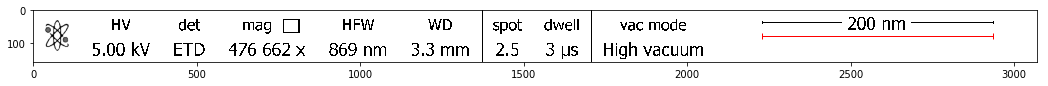

Please enter scalebar value in nm:  200


200 nm in 706 px, pixel width = 0.283 nm
2.8328611898017e-10 pixels per nm, 	 870.2549575070822 nm height 	 580.4532577903683 nm height


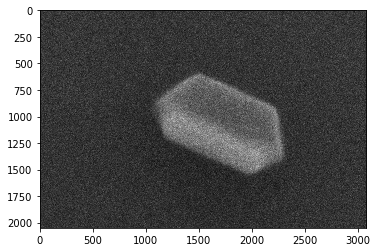

In [207]:
# Read, calibrate, and view image
im,raw_im,px,w,h = read_tif(fpaths[4])
#im,raw_im,px,w,h = alternate_calibration(fpaths[2],show_plot=True)
plt.imshow(im)
print(px, 'pixels per nm, \t',w/(1e-9), 'nm height \t',h/(1e-9),'nm height')

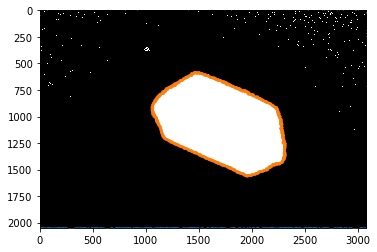

In [208]:
# Extract contours
c1 = extract_contours(im,method='blur_fill',plot=True)

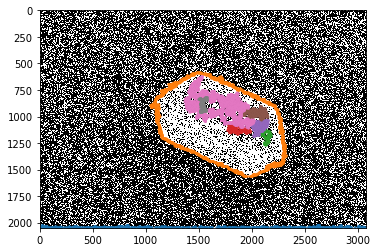

In [217]:
c2 = extract_contours(im,method='sobel',plot=True)

(3,)

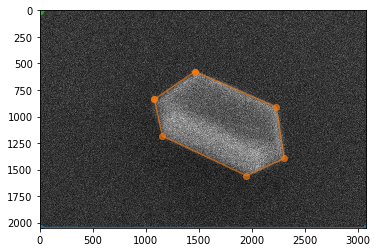

In [218]:
# simplify contours to shapes
s1 = detect_shapes(c1)
plot_shapes(s1,im)

np.shape(s1)

(9,)

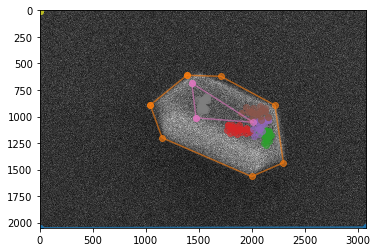

In [219]:
s2 = detect_shapes(c2)
plot_shapes(s2,im)

np.shape(s2)

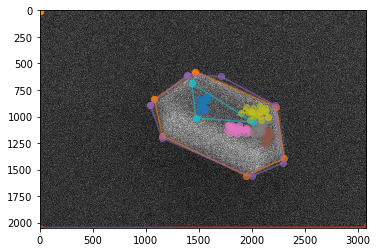

In [220]:
# Merge shapes from different filters together
all_s =np.concatenate((s1,s2))
#all_s = s1.append(s2)
plot_shapes(all_s,im)

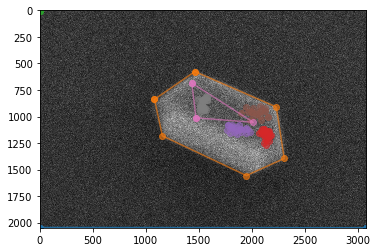

In [221]:
# Remove identical shapes
new_all_s = remove_identical_shapes(all_s,threshold=.3)
plot_shapes(new_all_s,im)

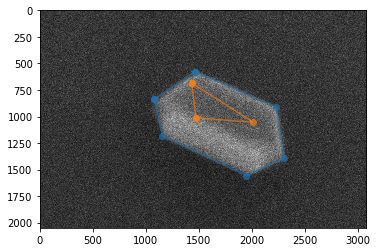

In [222]:
# remove weird shapes
filtered = post_filter(new_all_s,px,max_avg_length=200)
plot_shapes(filtered,im)

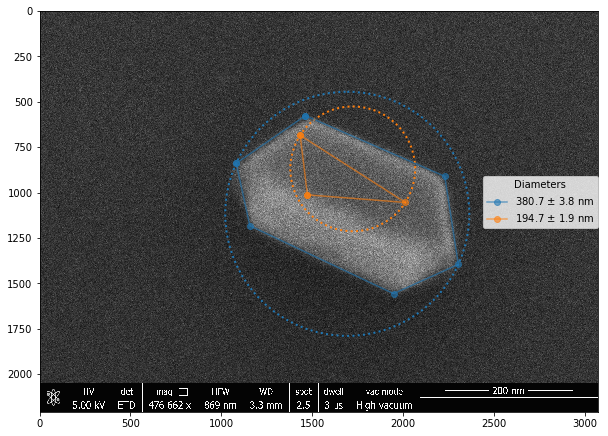

In [223]:
# Plot final measurements
poly_approx_thresh = 0.01
cents,rads = fit_circles(filtered)
ds = calibrate_radii(rads,px)
errs = np.array(ds) * poly_approx_thresh
plot_circles(raw_im,filtered,cents,rads,ds,errs)

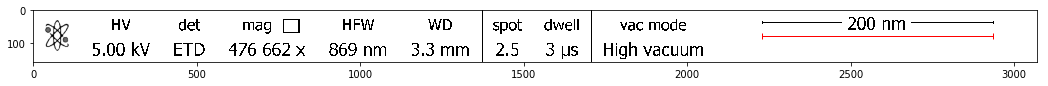

200 nm in 706 px, pixel width = 0.283 nm


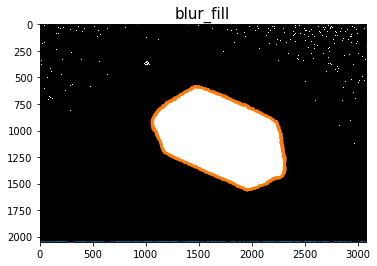

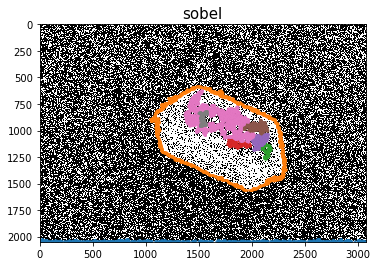

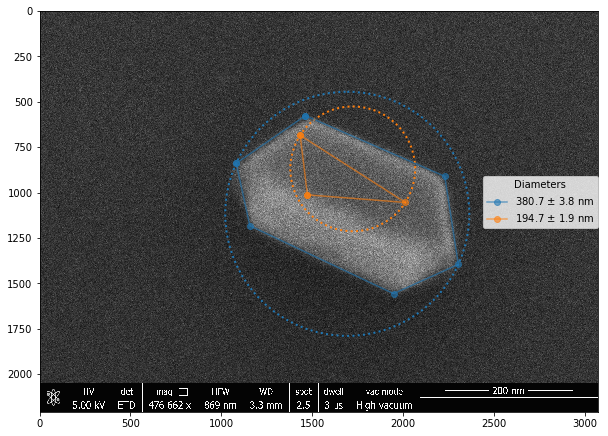

In [235]:
full_count_process(fpaths[4],scale_bar_val=200,max_avg_length=200,plot_filters=True)